In [52]:
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
from transform_factory import get_trivial_augment, resize_224, center_crop_224, resize_322, imagenet_normalize, tensorize, PIL2Tensor, get_spatial_transform
from expl import ExplFactory
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torchvision.transforms.functional import to_pil_image, resize, rotate

import torch

In [112]:
model = resnet50(weights = ResNet50_Weights.DEFAULT).eval().cuda()
img = Image.open("/home/juhyeon/Imagenet/val/n01484850/ILSVRC2012_val_00002338.JPEG")
expl_func = ExplFactory().get_explainer(model = model, expl_method = "GradCAM", upsample=False)


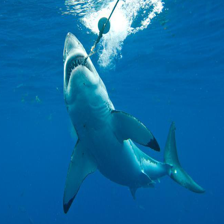

In [113]:
orig_img = center_crop_224(resize(img, (232, 232), InterpolationMode.BICUBIC))
orig_img



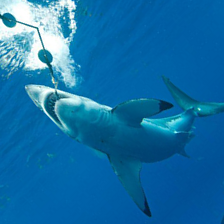

In [114]:
center_crop_224(rotate(Image.fromarray(np.pad(np.array(orig_img), ((49, 49), (49, 49), (0, 0)), mode="symmetric")), 45, InterpolationMode.BICUBIC))

In [130]:
orig_img = resize_322(img)
expl_img = resize_224(img)


center_img = center_crop_224(orig_img)

In [1]:
orig_img

NameError: name 'orig_img' is not defined

In [136]:
zero_out_img.shape

torch.Size([3, 322, 322])

In [137]:
center_img.shape

torch.Size([3, 224, 224])

In [139]:
zero_out_img[:, 49:273, 49:273] = center_img

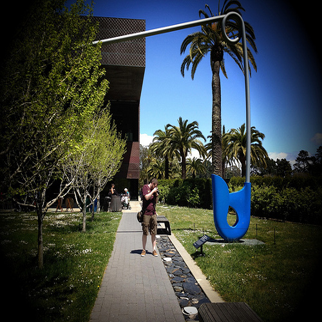

In [140]:
to_pil_image(zero_out_img)

In [88]:
# orig_img = F.pad(PIL2Tensor(orig_img), (49,49,49,49))


In [97]:
T_spatial, _, _ = get_spatial_transform()


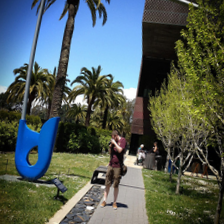

In [98]:
center_crop_224(T_spatial(orig_img))

In [ ]:
y = model(imagenet_normalize(tensorize(orig_img)).unsqueeze(0).cuda()).argmax()

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [61]:
orig_expl, _ = expl_func(imagenet_normalize(tensorize(orig_img)).unsqueeze(0).cuda(), y)

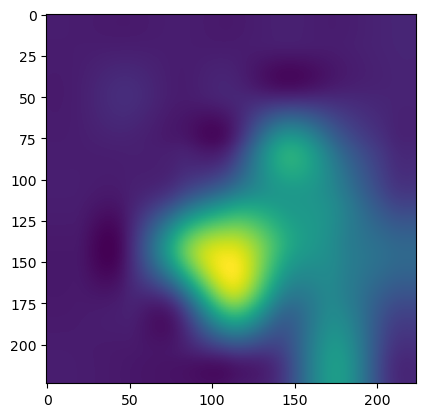

In [62]:
plt.imshow(F.interpolate(orig_expl, (224, 224), mode='bicubic').squeeze().detach().cpu())

In [63]:
T = get_trivial_augment()
trans_img = T(expl_img)

[('hflip', 1), ('Brightness', -0.296999990940094), ('Solarize', 212.5), ('Equalize', 0.0)]


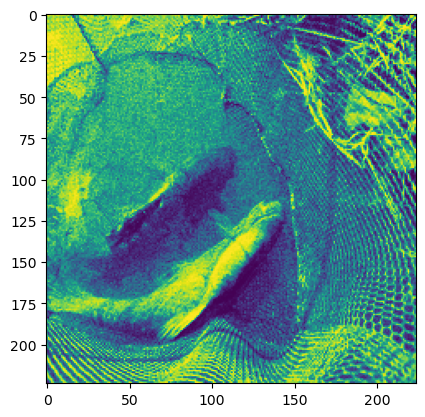

In [64]:
plt.imshow(trans_img.sum(0))
expl, pred = expl_func(trans_img.unsqueeze(0).cuda(), y)

In [65]:
_expl = center_crop_224(F.interpolate(expl, (322, 322), mode='bicubic'))
print(pred)

AttributeError: 'NoneType' object has no attribute 'dim'

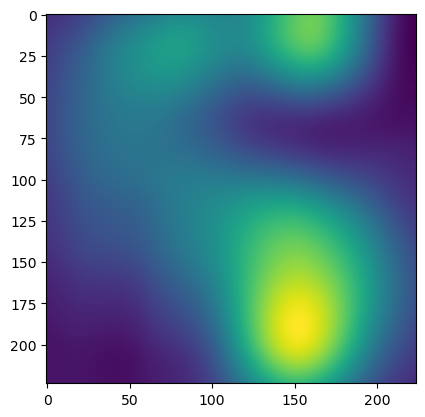

In [66]:
plt.imshow(_expl.squeeze().detach().cpu())

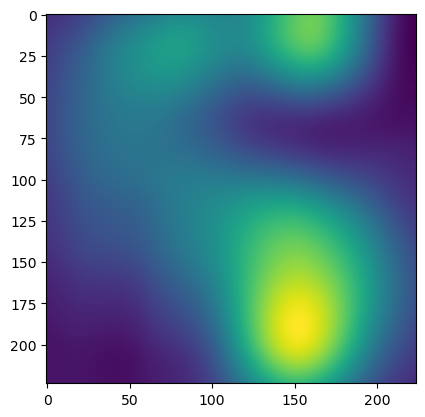

In [57]:
_expl = center_crop_224(T_inv_spatial(F.interpolate(expl, (322, 322), mode='bicubic')))
# _expl = center_crop_224(F.interpolate(expl, (322, 322), mode='bicubic'))




plt.imshow(_expl.squeeze().detach().cpu())

In [20]:
expr_path = "results/val_seed_0_dataset_center_crop_224_orig_input_method_center_crop_224_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/ILSVRC2012_val_00024718.JPEG_expl_GradCAM_sample_2000_sigma_0.05_seed_0_orig_true_config.npy" 
config_path = f"results/val_seed_0_dataset_center_crop_224_orig_input_method_center_crop_224_pred_orig_eval_orig_transform_both_sign_all_reduction_sum/ILSVRC2012_val_00024718.JPEG_expl_GradCAM_sample_2000_sigma_0.05_seed_0_transform_config.txt" 


In [21]:
with open(expr_path, "rb") as f:
    orig_expl = np.load(f, allow_pickle=True)
    true_expls = np.load(f, allow_pickle=True)
    # configs = np.load(f, allow_pickle=True)

with open(config_path, "r") as f:
    configs = f.readlines()

In [23]:
true_expls.shape

(2000, 1, 7, 7)

In [24]:
indicies = np.arange(0, 2000, 1)
np.random.shuffle(indicies)
cal_idx, val_idx = indicies[:1000], indicies[1000:]

configs = np.array(configs)

KeyboardInterrupt: 

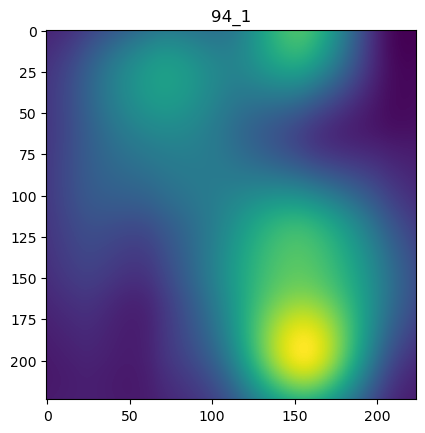

In [25]:
idx = 0
for true_expl, config in zip(true_expls[cal_idx], configs[cal_idx]):
    config = dict(eval(config))

    if 'Rotate' in config.keys():
        T_inv_spatial = transforms.Compose([
            transforms.RandomRotation((-config['Rotate'], -config['Rotate']), InterpolationMode.BILINEAR),
            transforms.RandomHorizontalFlip(config['hflip']),
            
        ])
    else:
        T_inv_spatial = transforms.Compose([
            transforms.RandomHorizontalFlip(config['hflip']),
        ])

    true_expl = center_crop_224(T_inv_spatial(F.interpolate(torch.tensor(true_expl).cuda().unsqueeze(0), (322, 322), mode='bicubic'))).squeeze(0)

    plt.imshow(true_expl.squeeze().detach().cpu())

    if 'Rotate' in config.keys():
        plt.title(f"{idx}_{config['hflip']}_{config['Rotate']}")
    else:
        plt.title(f"{idx}_{config['hflip']}")
    plt.savefig("./true_expl.jpeg")
    idx += 1
    


[('hflip', 0), ('Rotate', -130.5), ('Brightness', -0.8580000400543213), ('Color', -0.527999997138977), ('Contrast', -0.0), ('Sharpness', 0.7590000033378601), ('Posterize', 4.0), ('AutoContrast', 0.0)]



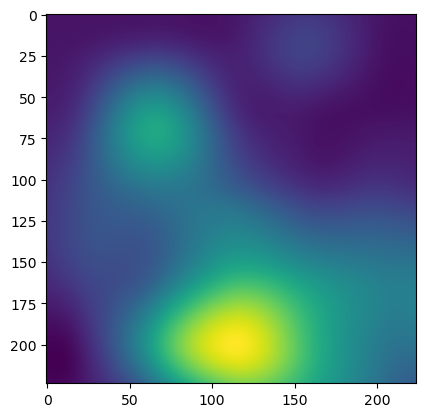

In [27]:
data_idx = 44

true_expl = center_crop_224(F.interpolate(torch.tensor(true_expls[cal_idx[data_idx]]).cuda().unsqueeze(0), (322, 322), mode='bicubic')).squeeze(0)
config = configs[cal_idx[data_idx]]
print(config)

config = dict(eval(config))
if 'Rotate' in config.keys():
    T_inv_spatial = transforms.Compose([
        transforms.RandomRotation((-config['Rotate'], -config['Rotate']), InterpolationMode.BILINEAR),

        transforms.RandomHorizontalFlip(config['hflip']),
        
    ])
else:
    T_inv_spatial = transforms.Compose([
        transforms.RandomHorizontalFlip(config['hflip']),
    ])
plt.imshow(true_expl.squeeze().detach().cpu())

true_expl = center_crop_224(T_inv_spatial(F.interpolate(torch.tensor(true_expls[cal_idx[data_idx]]).cuda().unsqueeze(0), (322, 322), mode='bicubic'))).squeeze(0)
# plt.imshow(true_expl.squeeze().detach().cpu())


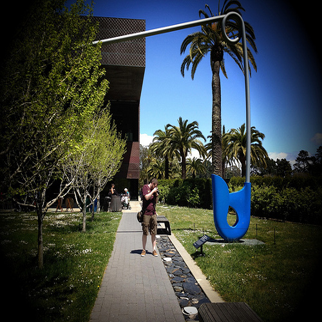

In [106]:
orig_img

In [118]:
mask = torch.where(true_expl > 0, torch.ones_like(true_expl), 0).detach().cpu()


# order = (mask * expl).flatten(1).argsort(descending=True)
order = (mask * conf_high).flatten(1).argsort(descending=True)

n_perturb = (ratio * order.shape[1]).type(torch.LongTensor).squeeze()
n_order = order[range(len(expl)), n_perturb]
# threshold = (mask * expl).flatten(1)[range(len(expl)), n_order]
threshold = (mask * conf_high).flatten(1)[range(len(expl)), n_order]

# our_mask = (mask * expl) > threshold.reshape(len(expl), 1, 1).unsqueeze(1)
our_mask = (mask * conf_high) > threshold.reshape(len(expl), 1, 1).unsqueeze(1)

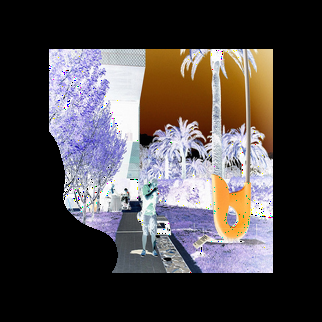

In [119]:
to_pil_image(PIL2Tensor(orig_img) * F.pad(mask, (49, 49, 49, 49)))

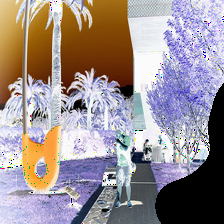

In [127]:
T_spatial, _, _ = get_spatial_transform()
center_crop_224(T_spatial(to_pil_image(PIL2Tensor(orig_img) * F.pad(mask, (49, 49, 49, 49)))))
